In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("data//yellow_tripdata_2016-05.csv",parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime']);
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


Ищем поездки без пассажиров

In [4]:
inds = df[df.passenger_count ==0].index;
print 'No passengers: ',len(inds),' trips';
df.drop(inds,inplace = True);

No passengers:  604  trips


Ищем поездки нулевой длительности

In [5]:
# create additional column - duration of the trip
df = df.assign(duration = df.tpep_dropoff_datetime - df.tpep_pickup_datetime);
# delete empty trips
inds = df[df.duration == pd.to_timedelta('0 days')].index;
print 'Zero duration: ',len(inds),' trips';
df.drop(inds,inplace = True);

Zero duration:  12186  trips


Ищем поездки с нулевым расстоянием по счётчику

In [6]:
# delete empty trips
inds = df[df.trip_distance == 0].index;
print 'Zero distance: ',len(inds),' trips';
df.drop(inds,inplace = True);

Zero distance:  60641  trips


Ищем поездки за пределами Нью-Йорка

In [7]:
#load coordinates of regions
regs = pd.read_csv("data\\regions.csv",sep=";",index_col='region');
# find corners of the New-York rectangular
east = regs.loc[:,'east'].max();
west = regs.loc[:,'west'].min();
south = regs.loc[:,'south'].min();
north = regs.loc[:,'north'].max();
# find outliers
inds = df[(df.pickup_longitude>east) | (df.pickup_longitude<west) | (df.pickup_latitude>north) | (df.pickup_latitude<south)].index;
df.drop(inds,inplace=True);

In [8]:
X = np.unique([regs.west,regs.east]);
Y = np.unique([regs.south,regs.north]);

In [9]:
from scipy.stats import binned_statistic_2d

In [10]:
[statistic, xEdge, yEdge, binNum] = binned_statistic_2d(df.pickup_longitude,df.pickup_latitude,
        df.index,statistic = 'count',bins = [X,Y]);

In [30]:
df = df.assign(regions = binNum);
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,regions
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,...,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,00:17:31,1333
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,...,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,00:07:31,1278
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,...,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,00:07:01,1278
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,...,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,00:19:47,1271
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,...,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,00:06:39,1226


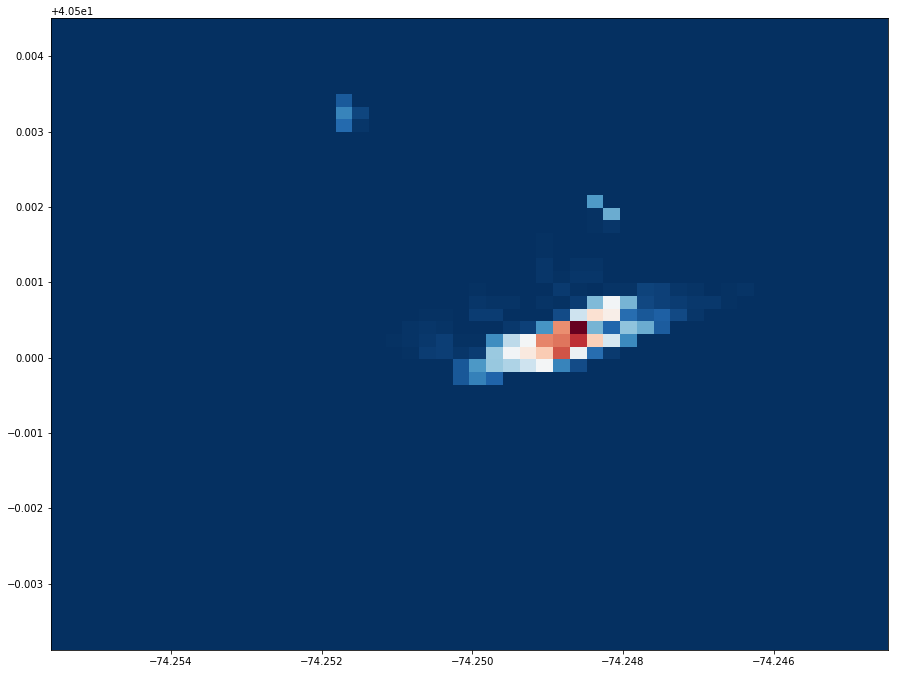

In [13]:
plt.figure(figsize=[15,15])
plt.imshow(statistic,cmap='RdBu_r', extent=[xEdge[0],xEdge[1], yEdge[0],yEdge[1]], interpolation='nearest', origin='lower')

In [53]:
gr = df.groupby(['regions', ],).size();

In [62]:
df.applymap(lambda x: x.tpep_pickup_datetime.hour)

AttributeError: ("'long' object has no attribute 'tpep_pickup_datetime'", u'occurred at index VendorID')